In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# ------------------------------------------------------
# 📂 0. 데이터 로드 & 초기 정리
# ------------------------------------------------------
data_path = 'data/datasets.csv'
data = pd.read_csv(data_path)

In [3]:
# 불필요한 컬럼 제거
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
data.drop(columns=drop_cols, inplace=True)

In [4]:
# 타겟값 변환
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

In [5]:
# ------------------------------------------------------
# ⚠️ 1. 이상값 및 결측 처리
# ------------------------------------------------------
# 0으로 나누기 방지용 NaN 처리
data['TotalWorkingYears'] = data['TotalWorkingYears'].replace(0, np.nan)
data['YearsAtCompany'] = data['YearsAtCompany'].replace(0, np.nan)

In [6]:
# ------------------------------------------------------
# 🎯 2. 커리어 관련 파생 변수
# ------------------------------------------------------
data['CareerStartAge'] = data['Age'] - data['TotalWorkingYears']                  # 첫 커리어 시작 나이
data['LoyaltyRatio'] = data['YearsAtCompany'] / data['TotalWorkingYears']        # 충성도 비율
data['PromotionDelay'] = data['YearsAtCompany'] - data['YearsSinceLastPromotion']# 승진까지 소요 기간


In [7]:
# ------------------------------------------------------
# 🏢 3. 근속 관련 파생 변수
# ------------------------------------------------------
data['CompanyLoyalty'] = data['YearsAtCompany'] / data['TotalWorkingYears']      # 회사 전체 근속 비율
data['RoleStability'] = data['YearsInCurrentRole'] / data['YearsAtCompany']      # 현재 직무 지속 비율
data['ManagerBond'] = data['YearsWithCurrManager'] / data['YearsAtCompany']      # 매니저 유대 비율

In [8]:
# ------------------------------------------------------
# 🔁 4. 이직/승진 경향
# ------------------------------------------------------
data['JobHopFrequency'] = data['NumCompaniesWorked'] / data['TotalWorkingYears'] # 연평균 이직 횟수
data['RecentlyPromoted'] = (data['YearsSinceLastPromotion'] <= 3).astype(int)     # 최근 3년 내 승진 여부

In [9]:
# ------------------------------------------------------
# 💰 5. 급여 및 성과 관련 변수
# ------------------------------------------------------
data['IncomePerYear'] = data['MonthlyIncome'] / data['TotalWorkingYears']        # 경력 대비 소득
data['HighPerformerQuit'] = ((data['PerformanceRating'] == 4) & 
                             (data['Attrition'] == 1)).astype(int)                # 고성과 이탈자 여부

In [10]:
# ------------------------------------------------------
# 🛣️ 6. 스트레스 및 이동 관련 변수
# ------------------------------------------------------
data['LongCommute'] = (data['DistanceFromHome'] > 20).astype(int)                # 장거리 출퇴근 여부
data['OverworkedPoorBalance'] = ((data['OverTime'] == 'Yes') & 
                                 (data['WorkLifeBalance'] <= 2)).astype(int)      # 워라밸 붕괴 여부

In [11]:
# ------------------------------------------------------
# 😊 7. 종합 만족도
# ------------------------------------------------------
data['OverallSatisfaction'] = (
    data['EnvironmentSatisfaction'] + 
    data['JobSatisfaction'] + 
    data['RelationshipSatisfaction']
) / 3                                                                             # 평균 만족도

In [12]:
# ------------------------------------------------------
# 🧑‍💼 8. 직급 기반 고위직 구분
# ------------------------------------------------------
manager_roles = ['Manager', 'Research Director']
data['Is_Manager'] = ((data['JobRole'].isin(manager_roles)) & 
                      (data['JobLevel'] >= 3)).astype(int)                        # 고위직 여부

In [13]:
# ------------------------------------------------------
# 🧹 9. 결측값 정리
# ------------------------------------------------------
data.fillna(0, inplace=True)

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


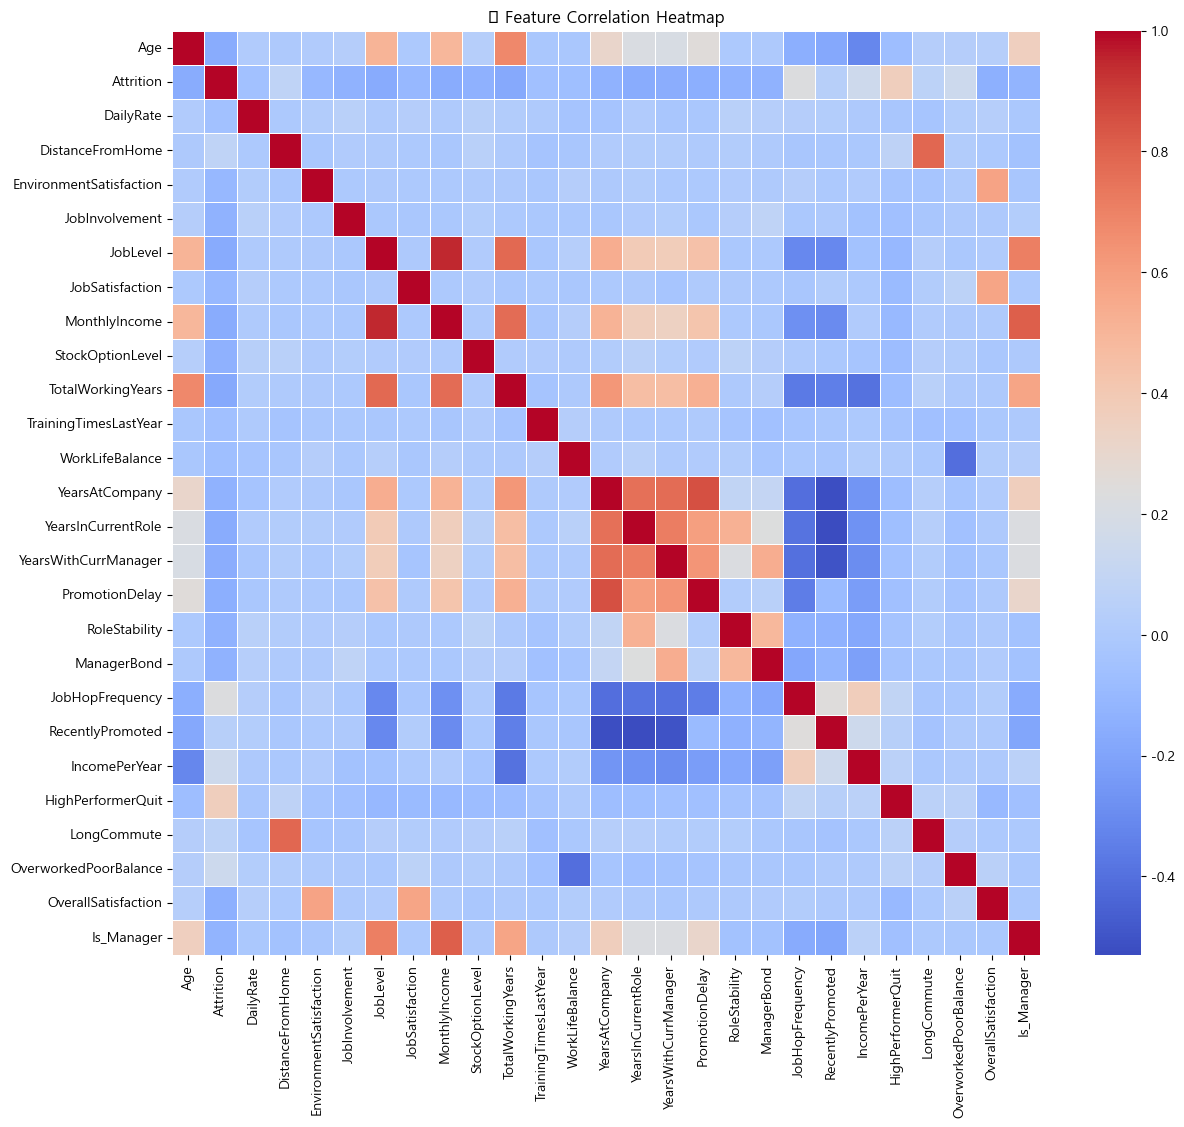

C:\Users\jhwoo\AppData\Local\Temp\ipykernel_32448\3813294372.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='RdBu')
C:\Users\jhwoo\AppData\Local\Temp\ipykernel_32448\3813294372.py:25: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


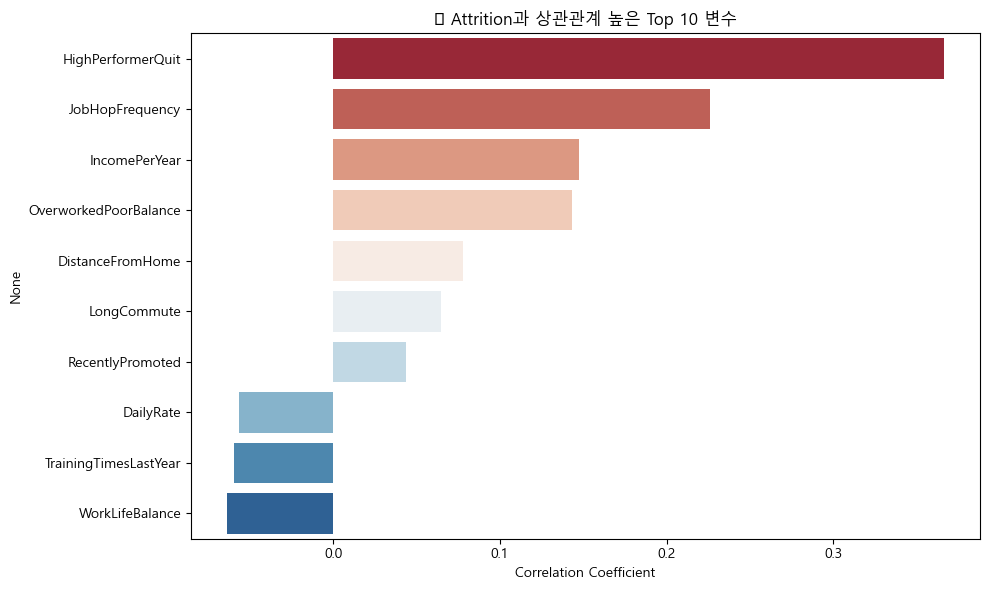

C:\Users\jhwoo\AppData\Local\Temp\ipykernel_32448\3813294372.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='RdBu')
C:\Users\jhwoo\AppData\Local\Temp\ipykernel_32448\3813294372.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


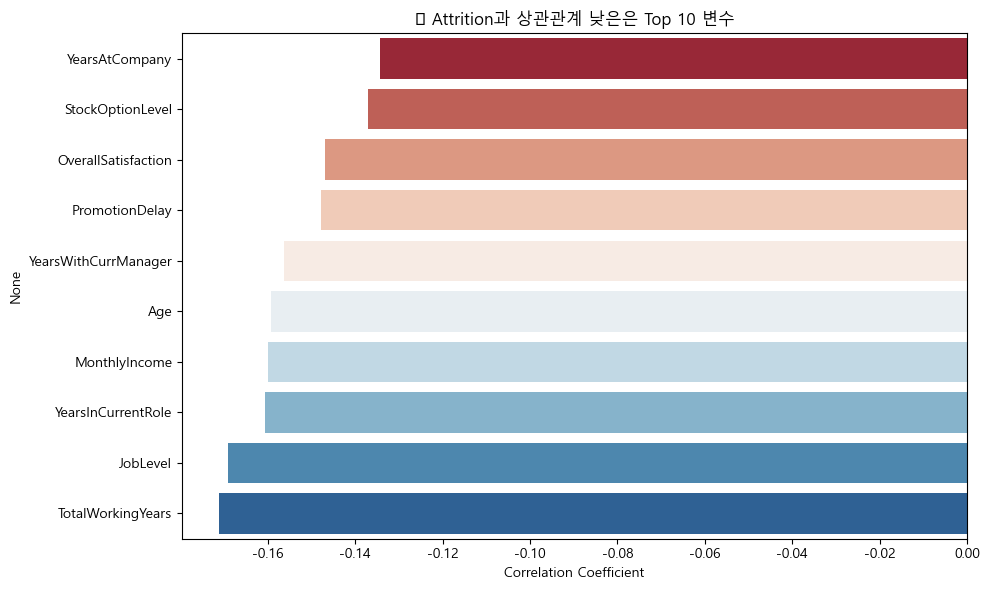

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 수치형 컬럼만 추출
numeric_features = data.select_dtypes(include=[np.number])

# 2. 상관계수 계산
corr_matrix = numeric_features.corr()

# 3. Attrition과 상관관계가 높은 순으로 정렬
target_corr = corr_matrix['Attrition'].sort_values(ascending=False)

# 4. 전체 heatmap 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('🔥 Feature Correlation Heatmap')
plt.show()

# 5. Attrition 상관계수 상위 10개만 시각화 (타겟 중심 분석)
top_corr_features = target_corr[1:11]  # 0번째는 Attrition 자기 자신
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='RdBu')
plt.title('🎯 Attrition과 상관관계 높은 Top 10 변수')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# 5. Attrition 상관계수 상위 10개만 시각화 (타겟 중심 분석)
top_corr_features = target_corr[-10:]  # 0번째는 Attrition 자기 자신
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='RdBu')
plt.title('🎯 Attrition과 상관관계 낮은은 Top 10 변수')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


In [22]:
# 숫자형 컬럼만 골라서 상관관계 계산
num_cols = data.select_dtypes(include=['int64', 'float64'])
corrs = num_cols.corr()['Attrition'].abs().sort_values()

# 상관계수 낮은 피처 추출
weak_corr = corrs[corrs < 0.01].index.tolist()
print(weak_corr)


['PerformanceRating', 'HourlyRate']


In [24]:
drop_these = [
    'HourlyRate', 'MonthlyRate', 'PercentSalaryHike', 
    'LoyaltyRatio', 'CompanyLoyalty', 'Education', 
    'CareerStartAge', 'NumCompaniesWorked', 
    'RelationshipSatisfaction', 'PerformanceRating', 'YearsSinceLastPromotion',
]
data.drop(columns=drop_these, inplace=True)

In [26]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,RoleStability,ManagerBond,JobHopFrequency,RecentlyPromoted,IncomePerYear,HighPerformerQuit,LongCommute,OverworkedPoorBalance,OverallSatisfaction,Is_Manager
0,41,1,Travel_Rarely,1102,Sales,1,Life Sciences,2,Female,3,...,0.666667,0.833333,1.000000,1,749.125000,0,0,1,2.333333,0
1,49,0,Travel_Frequently,279,Research & Development,8,Life Sciences,3,Male,2,...,0.700000,0.700000,0.100000,1,513.000000,0,0,0,3.000000,0
2,37,1,Travel_Rarely,1373,Research & Development,2,Other,4,Male,2,...,0.000000,0.000000,0.857143,1,298.571429,0,0,0,3.000000,0
3,33,0,Travel_Frequently,1392,Research & Development,3,Life Sciences,4,Female,3,...,0.875000,0.000000,0.125000,1,363.625000,0,0,0,3.333333,0
4,27,0,Travel_Rarely,591,Research & Development,2,Medical,1,Male,3,...,1.000000,1.000000,1.500000,1,578.000000,0,0,0,2.333333,0


In [27]:
# ------------------------------------------------------
# ⚙️ 10. 컬럼 타입 분리
# ------------------------------------------------------
numeric_features = data.select_dtypes(include=['int64', 'float64']).drop(columns=['Attrition']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

In [29]:
# ------------------------------------------------------
# 🧪 11. 전처리 파이프라인 구성 및 적용
# ------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 각 모델에 대해 하이퍼파라미터 그리드 정의
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],  # 정규화 파라미터
        'classifier__solver': ['liblinear', 'saga']  # Solver 선택
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5],
        'classifier__max_depth': [3, 5, 7]
    },
    'Naive Bayes': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 6]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 50]
    },
    'CatBoost': {
        'classifier__iterations': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__depth': [3, 5, 7]
    }
}
# 8. 전체 파이프라인 구성
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=3000))
])

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

gb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

lgbm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])

cat_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier())
])

In [33]:
from sklearn.model_selection import train_test_split

# 9. 데이터 분리
X = data.drop(columns='Attrition')
y = data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)


In [34]:
# 10. 학습 및 예측
clf_list = [lr_clf, rf_clf, gb_clf, nb_clf, xgb_clf, lgbm_clf, cat_clf]
best_acc = 0.0
best_clf = None
best_model_name = ""
best_params = {}

# 2. GridSearchCV를 사용한 모델 학습 및 하이퍼파라미터 튜닝
for clf, model_name in zip(clf_list, param_grids.keys()):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # 가장 좋은 성능의 모델과 파라미터 저장
    if grid_search.best_score_ > best_acc:
        best_acc = grid_search.best_score_
        best_clf = grid_search.best_estimator_
        best_model_name = model_name
        best_params = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 152, number of negative: 788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161702 -> initscore=-1.645618
[LightGBM] [Info] Start training from score -1.645618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[Li

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[Li

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161702 -> initscore=-1.645618
[LightGBM] [Info] Start training from score -1.645618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You 

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161702 -> initscore=-1.645618
[LightGBM] [Info] Start training from score -1.645618
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No 

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[Li

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[Li

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[Li

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161702 -> initscore=-1.645618
[LightGBM] [Info] Start training from score -1.645618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 941, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161530 -> initscore=-1.646886
[LightGBM] [Info] Start training from score -1.646886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jhwoo\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.6861204	total: 146ms	remaining: 14.5s
1:	learn: 0.6804693	total: 149ms	remaining: 7.32s
2:	learn: 0.6737971	total: 151ms	remaining: 4.89s
3:	learn: 0.6659648	total: 153ms	remaining: 3.67s
4:	learn: 0.6596707	total: 154ms	remaining: 2.93s
5:	learn: 0.6540467	total: 155ms	remaining: 2.44s
6:	learn: 0.6474475	total: 156ms	remaining: 2.08s
7:	learn: 0.6425753	total: 158ms	remaining: 1.81s
8:	learn: 0.6377361	total: 159ms	remaining: 1.6s
9:	learn: 0.6327147	total: 160ms	remaining: 1.44s
10:	learn: 0.6275535	total: 161ms	remaining: 1.3s
11:	learn: 0.6227679	total: 162ms	remaining: 1.19s
12:	learn: 0.6167930	total: 163ms	remaining: 1.09s
13:	learn: 0.6108792	total: 164ms	remaining: 1.01s
14:	learn: 0.6059089	total: 165ms	remaining: 933ms
15:	learn: 0.6016157	total: 165ms	remaining: 869ms
16:	learn: 0.5975189	total: 166ms	remaining: 811ms
17:	learn: 0.5925507	total: 167ms	remaining: 761ms
18:	learn: 0.5877356	total: 168ms

In [37]:
# 3. 최적의 모델로 예측 및 평가
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1]  # Yes일 확률

# 평가 출력
print(f"Best Model: {best_model_name}")
print(f"Best Hyperparameters: {best_params}")
print(classification_report(y_test, y_pred))
print("==============================")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("==============================")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

Best Model: Logistic Regression
Best Hyperparameters: {'classifier__C': 10, 'classifier__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       247
           1       0.73      0.47      0.57        47

    accuracy                           0.89       294
   macro avg       0.82      0.72      0.75       294
weighted avg       0.88      0.89      0.88       294

Accuracy: 0.8877551020408163
ROC AUC: 0.8660


In [38]:
from sklearn.metrics import classification_report, roc_auc_score

# 확률 예측 (Attrition=1일 확률)
y_proba = best_clf.predict_proba(X_test)[:, 1]
def evaluate_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    print(f"🔻 Threshold = {threshold:.3f}")
    print(f"accuracy:{accuracy_score(y_test,y_pred)}")
    # print(classification_report(y_true, y_pred, zero_division=0))
    # print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.4f}")
for t in [0.3, 0.35, 0.4, 0.45, 0.5]:
    evaluate_threshold(y_test, y_proba, threshold=t)


🔻 Threshold = 0.300
accuracy:0.8673469387755102
🔻 Threshold = 0.350
accuracy:0.8843537414965986
🔻 Threshold = 0.400
accuracy:0.891156462585034
🔻 Threshold = 0.450
accuracy:0.8945578231292517
🔻 Threshold = 0.500
accuracy:0.8877551020408163
